# Problem Statement
The ultimate goal of this project is to come up with an **accurate prediction model to forecast daily sales for the entire US** . In this project, I am going to build a LSTM time series forecasting model. In the data science world, the RNN family models, such as LSTM, are one of the most basic and effective time series forecasting model. If you are interested in the theory and mathmetic behind Recurrent Neural Network and LSTM, the medium post written by Joseph (Iosif) Mushailov and the youtube video created by Greg Hogg will give you a very comprehensive understanding. The links to the post and video are attached below.
  
In the original data, it records all the order history of all the stores from **2015/01/12 to 2018/12/30**. Originally, the order could be categorized into different product category and sub-categories. Yet, given that the goal of this project is to predict daily overall sales of the entire US, I will group the sales by date and sum the sales. 
  
Post: **[https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e](https://towardsdatascience.com/lstm-framework-for-univariate-time-series-prediction-d9e7252699e)**  
Video: **[https://www.youtube.com/watch?v=c0k-YLQGKjY](https://www.youtube.com/watch?v=c0k-YLQGKjY)**  



In [90]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import tensorflow
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
import os
os.getcwd()
os.chdir('/Users/haochunniu/Desktop/Kaggle Compatition/Sales Prediction')

## 1. Data pre-processing & cleaning
In this section, I imported the raw data and did some basic data cleaning. In the end, I finished the following four steps.  
  
**Step1: Read in raw data**  
**Step2: Drop columns that are not useful**  
**Step3: Group by time stamp and create a time series**  
**Step4: Quick time series decomposition plot** 



In [91]:
#Step1: Read in the raw data and turn the datetime into right data type
raw1=pd.read_csv('raw.csv')
raw1['Order Date']=pd.to_datetime(raw1['Order Date'])
raw1.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-08-11,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,2017-08-11,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94
2,3,CA-2017-138688,2017-12-06,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62


In [92]:
#Step2: Keep only the column required
raw2=raw1[['Order Date','Sales']]

#Step3: Group by into time series format
raw3=raw2.groupby('Order Date').agg({'Sales':'sum'})
raw3.head(3)

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,2203.151
2015-01-04,119.888


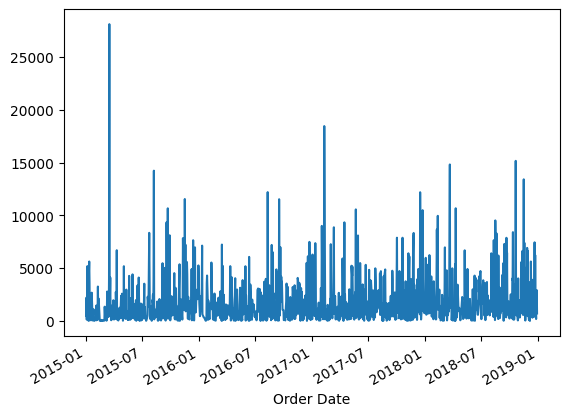

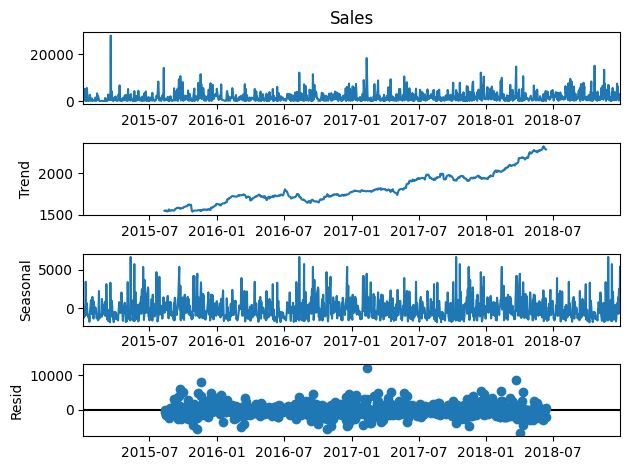

In [93]:
#Step4: Quick decomposition plot of time series
decom_plot=seasonal_decompose(raw3['Sales'], model='additive',period=365)
raw3['Sales'].plot()
decom_plot.plot()
print()

## 2. Train, validation, and test split
There are totally 1230 days' sales in the raw data. We use the first 70% as train data ( 2015/01/02 - 2017/11/10 ). Then, the next 20% would be used as the validation data ( 2017/11/11 - 2018/08/18 ). Lastly, the last 10% will be used as the test data ( 2018/08/19 - 2018/12/30 ).

In [94]:
raw4=raw3.sort_index()
train=raw4.iloc[:861,:]
val=raw4.iloc[861:1107,:]
test=raw4.iloc[1107:,:]
all_train=raw4.iloc[:1107,:]
print('There are totally {} rows in train data.'.format(len(train)))
print('There are totally {} rows in validation data.'.format(len(val)))
print('There are totally {} rows in test data.'.format(len(test)))

There are totally 861 rows in train data.
There are totally 246 rows in validation data.
There are totally 123 rows in test data.


## 3. Build the LSTM time series model
In this section, I start to build the LSTM time series model, using Tensorflow. In order to feed into LSTM, I need to format the train dataset into a sepcific format. Below shows the sample format of a LSTM model input. After formating the input into right format, I will use **random search** to help me find the best hyper-parameter combinations for the LSTM model.   
    
**Ex:**   
5 days' sales time series [11,17,18,21,22]  
LSTM model taking previous **2** periods into account while predicting
  
There will be two important inputs, **X and Y**.
  
X -> [[11,17],[17,18],[18,21]]  
Y -> [18,21,22]  
  
   
----------------------------------------------------------------------------------------------------------------------------------------------------
The entire process could be concluded into the following steps.

**Step1: Create the function to reshape the input data for LSTM model**  
**Step2: Reshape the input time series**  
**Step3: Import all packages for the LSTM model**   
**Step4: Random search on LSTM model to find the best hyper-parameters**  
**Step5: Build and fit the final LSTM model with the best hyper-parameters** 




In [95]:
#Step1: Create a function to transform the original time series into LSTM input format
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [96]:
#Step2: Reshape the time series into the format
#Given that we have enough time series, we first try look_back period as 30
look_back = 20
n_features = 1
trainX, trainY = create_dataset(train['Sales'], look_back)
valX, valY = create_dataset(val['Sales'], look_back)
testX, testY = create_dataset(test['Sales'], look_back)
all_trainX, all_trainY = create_dataset(all_train['Sales'],look_back)

#Reshape the X input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back,n_features))
valX = np.reshape(valX, (valX.shape[0], look_back, n_features))
testX = np.reshape(testX, (testX.shape[0], look_back, n_features))
all_trainX = np.reshape(all_trainX,(all_trainX.shape[0], look_back, n_features))

In [97]:
#Step3: Import the packages for LSTM model
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [98]:
#Step4-1: Turn the sample LSTM model structure into an random search
#Create the NN structure
def build_model(hp):
    model1 = keras.Sequential()
    model1.add(LSTM(units=hp.Int('units',
                                 min_value=10,
                                 max_value=500,
                                 step=10),
                    activation='relu',
                    return_sequences=True,
                    input_shape=(look_back, n_features),
                    dropout=0.2))
    model1.add(LSTM(units=hp.Int('units',
                                 min_value=10,
                                 max_value=500,
                                 step=10),
                    activation='relu',
                    return_sequences=True,
                    input_shape=(look_back, n_features),
                    dropout=0.2))
    model1.add(layers.Dense(1,activation='linear'))
    model1.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.01,0.001,0.0001])),
                   loss='mse',
                   metrics=['mse'])
    return model1

tuner=RandomSearch(build_model,
                   objective='mse',
                   max_trials=3,
                   executions_per_trial=2,
                   overwrite=True) #Remember to set overwrite = True so we can tune multiple times

In [99]:
#Step4-3: Start the random search
random.seed(99)
tuner.search(x=trainX,y=trainY,epochs=100,batch_size=64,validation_data=(valX,valY))

Trial 3 Complete [00h 11m 10s]
mse: 5666910.25

Best mse So Far: 5666910.25
Total elapsed time: 00h 23m 40s
INFO:tensorflow:Oracle triggered exit


In [11]:
#Step4-4: Result of the tuner
result=tuner.get_best_hyperparameters()[0].values
print('The best 2 layers NN parameters would be {} neurons and {} learning rate.'.format(result['units'],result['learning_rate']))
print('------------------------------------------')
print(tuner.results_summary())

The best 2 layers NN parameters would be 300 neurons and 0.001 learning rate.
------------------------------------------
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 300
learning_rate: 0.001
Score: 5614065.5
Trial summary
Hyperparameters:
units: 240
learning_rate: 0.01
Score: 5850012.0
Trial summary
Hyperparameters:
units: 80
learning_rate: 0.0001
Score: 6436740.5
None


In [100]:
#Step5-1: Define the final LSTM model
#This is a two layers LSTM model
random.seed(99)
model_final = Sequential()
model_final.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model_final.add(LSTM(300, activation='relu'))
model_final.add(Dense(1))
model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model_final.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0)

8/8 [==============================] - 0s 20ms/step



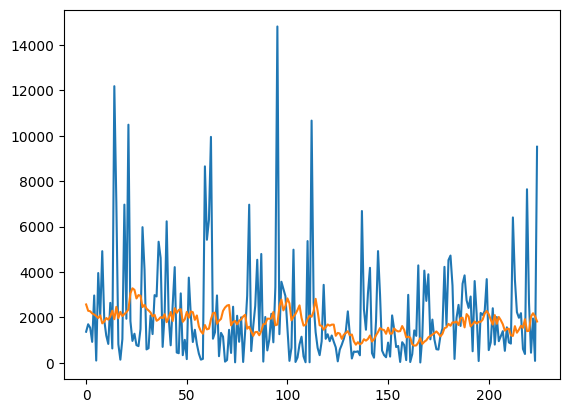

RMSE on validation data: 2359.0890109649818


In [101]:
#Step5-2: Veification the final model on validation data
val_predict=model_final.predict(valX)
print()
plt.plot(valY)
plt.plot(val_predict)
plt.show()

#Step6: Calculate the MSE
val_rmse=math.sqrt(mean_squared_error(valY,val_predict))
print('RMSE on validation data: {}'.format(val_rmse))

## 4. Retrain the model on train + validation data
After finalizing the model I will use, I will **train the model again on the overall training data, including both train and validation datas**. Lastly, I will make the final predictions on the test data and evaluate model's final performance.

In [102]:
random.seed(99)
model_final = Sequential()
model_final.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model_final.add(LSTM(300, activation='relu'))
model_final.add(Dense(1))
model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model_final.fit(all_trainX, all_trainY, epochs=100, batch_size=32, verbose=0)


4/4 [==============================] - 0s 22ms/step



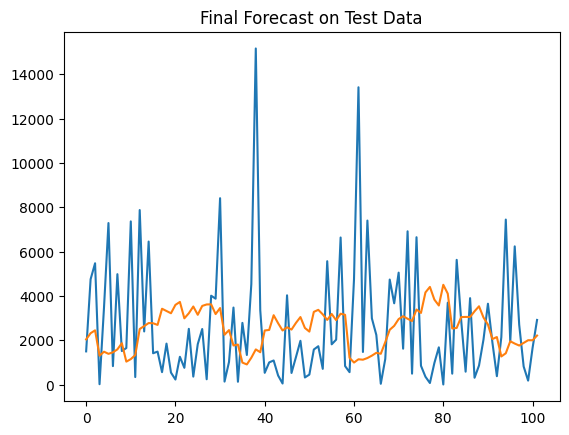

RMSE on test data: 3075.2838554967148


In [103]:
#Veification the final model on test data
test_predict=model_final.predict(testX)
print()
plt.plot(testY)
plt.plot(test_predict)
plt.title('Final Forecast on Test Data')
plt.show()

#Step6: Calculate the MSE
test_rmse=math.sqrt(mean_squared_error(testY,test_predict))
print('RMSE on test data: {}'.format(test_rmse))